In [2]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [3]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.12.0
/device:GPU:0


In [4]:
%cd /kaggle/input/food-101/

/kaggle/input/food-101


In [5]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [6]:
# Download data and extract it to folder
# Uncomment this below line if you are on Colab

#get_data_extract()

In [7]:
# Check the extracted dataset folder
!ls food-101/

README.txt  images  license_agreement.txt  meta


In [8]:
os.listdir('food-101/images')

['falafel',
 'ramen',
 'pho',
 'ice_cream',
 'caprese_salad',
 'hot_dog',
 'steak',
 'baklava',
 'garlic_bread',
 'caesar_salad',
 'lobster_roll_sandwich',
 'carrot_cake',
 'mussels',
 'lobster_bisque',
 'bibimbap',
 'pancakes',
 'ceviche',
 'bread_pudding',
 'shrimp_and_grits',
 'chocolate_mousse',
 'eggs_benedict',
 'edamame',
 'creme_brulee',
 'cheesecake',
 'greek_salad',
 'beignets',
 'beef_tartare',
 'tuna_tartare',
 'takoyaki',
 'nachos',
 'sushi',
 'chocolate_cake',
 'fried_calamari',
 'foie_gras',
 'ravioli',
 'huevos_rancheros',
 'club_sandwich',
 'grilled_salmon',
 'paella',
 '.DS_Store',
 'deviled_eggs',
 'chicken_quesadilla',
 'hot_and_sour_soup',
 'fried_rice',
 'red_velvet_cake',
 'onion_rings',
 'scallops',
 'chicken_curry',
 'baby_back_ribs',
 'macarons',
 'bruschetta',
 'cup_cakes',
 'peking_duck',
 'french_toast',
 'filet_mignon',
 'gnocchi',
 'crab_cakes',
 'fish_and_chips',
 'french_onion_soup',
 'risotto',
 'dumplings',
 'hamburger',
 'hummus',
 'poutine',
 'clam_

In [9]:
os.listdir('food-101/meta')

['train.json',
 'test.json',
 'labels.txt',
 'test.txt',
 'classes.txt',
 'train.txt']

In [10]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [11]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


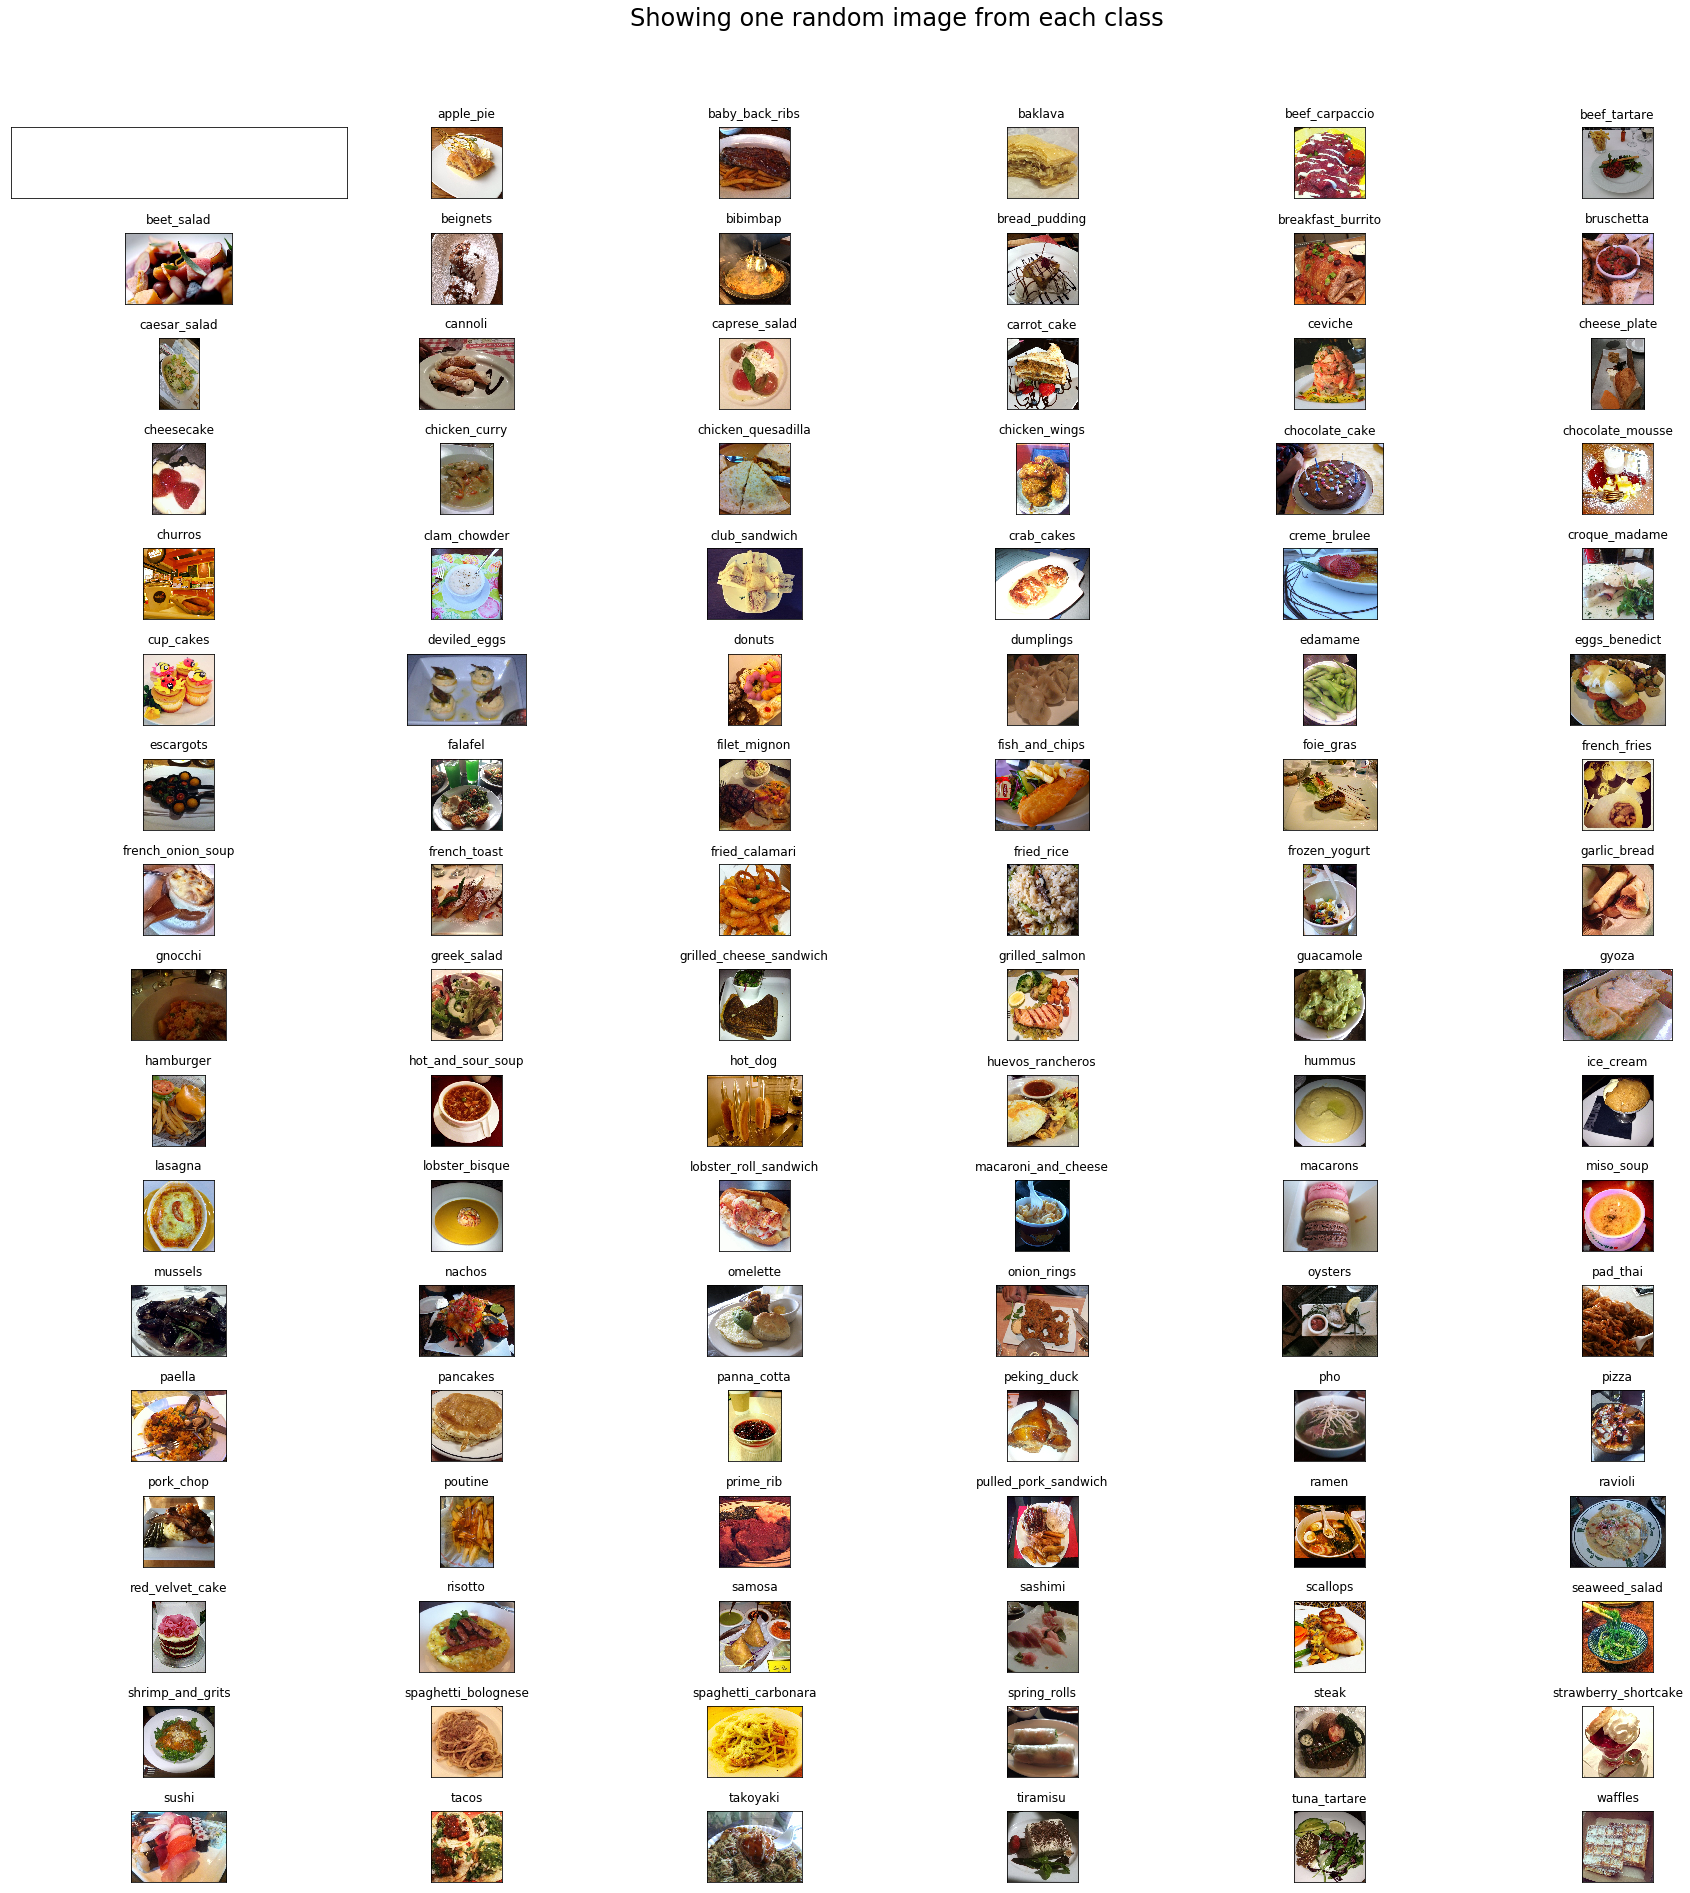

In [12]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [13]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [14]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [15]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [16]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [17]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [18]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [19]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [20]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [21]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [22]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [23]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [24]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [25]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [26]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1, 
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/30
139/140 [============================>.] - ETA: 0s - loss: 1.0893 - acc: 0.4501
Epoch 00001: val_loss improved from inf to 0.92127, saving model to best_model_3class.hdf5
140/140 [==============================] - 95s 680ms/step - loss: 1.0884 - acc: 0.4513 - val_loss: 0.9213 - val_acc: 0.6821
Epoch 2/30
139/140 [============================>.] - ETA: 0s - loss: 0.8915 - acc: 0.6586
Epoch 00002: val_loss improved from 0.92127 to 0.74755, saving model to best_model_3class.hdf5
140/140 [==============================] - 61s 439ms/step - loss: 0.8910 - acc: 0.6593 - val_loss: 0.7475 - val_acc: 0.7812
Epoch 3/30
139/140 [============================>.] - ETA: 0s - loss: 0.7397 - acc: 0.7474
Epoch 00003: val_loss improved from 0.74755 to 0.59854, saving model to best_model_3class.hdf5
140/140 [==============================] - 61s 435ms/step - loss: 0.7394 - acc: 0.7474 - val_loss: 0.5985 - val_acc

Epoch 30/30
139/140 [============================>.] - ETA: 0s - loss: 0.1153 - acc: 0.9735
Epoch 00030: val_loss improved from 0.17317 to 0.17236, saving model to best_model_3class.hdf5
140/140 [==============================] - 59s 422ms/step - loss: 0.1157 - acc: 0.9732 - val_loss: 0.1724 - val_acc: 0.9511


In [27]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [28]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


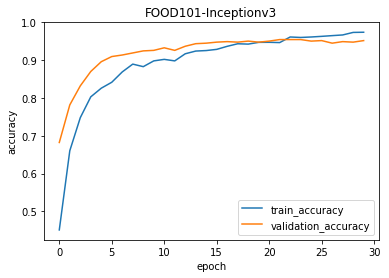

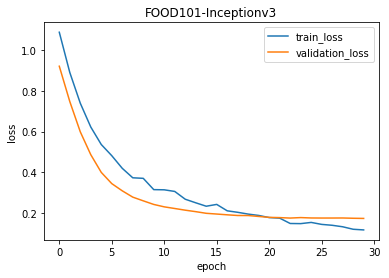

In [29]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [30]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 10 s, sys: 271 ms, total: 10.3 s
Wall time: 10.3 s


In [31]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [32]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2020-08-01 22:22:30--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   249KB/s    in 0.3s    

2020-08-01 22:22:30 (249 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2020-08-01 22:22:31--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K  --.-KB/s    in 0.1s

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list
  

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

In [ ]:
print("Total number of samples in train folder")
!find train_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

In [ ]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

In [ ]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')


In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

In [ ]:
plot_accuracy(history_11class,'FOOD101-Inceptionv3')
plot_loss(history_11class,'FOOD101-Inceptionv3')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

In [ ]:
# Downloading images from internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://upload.wikimedia.org/wikipedia/commons/6/6f/Vietnamese_spring_rolls.jpg
!wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


# from google.colab import files
# image = files.upload()

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

![](https://s3-media2.fl.yelpcdn.com/bphoto/7BlRoSOG3AsAWHMPOaG7ng/ls.jpg)

![](https://images.deepai.org/publication-preview/visualizing-and-understanding-convolutional-networks-page-4-medium.jpg)

In [ ]:
# Load the saved model trained with 3 classes
K.clear_session()
print("Loading the model..")
model = load_model('best_model_3class.hdf5',compile = False)
print("Done!")


In [ ]:
model.summary()

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [ ]:
def get_activations(img, model_activations):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255. 
    plt.imshow(img[0])
    plt.show()
    return model_activations.predict(img)
    

In [ ]:
def show_activations(activations, layer_names):
    
    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()



In [ ]:
len(model.layers)

In [ ]:
# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)

In [ ]:
layers

In [ ]:
layer_names = []
for layer in model.layers[1:11]:
    layer_names.append(layer.name)
print(layer_names)

In [ ]:
food = 'applepie.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

In [ ]:
food = 'pizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

In [ ]:
# Get the index of activation_1 layer which has sparse activations
ind = layer_names.index('activation_1')
sparse_activation = activations[ind]
a = sparse_activation[0, :, :, 13]
a

In [ ]:
all (np.isnan(a[j][k])  for j in range(a.shape[0]) for k in range(a.shape[1]))

In [ ]:
# Get the index of batch_normalization_1 layer which has sparse activations
ind = layer_names.index('batch_normalization_1')
sparse_activation = activations[ind]
b = sparse_activation[0, :, :, 13]
b

In [ ]:
first_convlayer_activation = activations[0]
second_convlayer_activation = activations[3]
third_convlayer_activation = activations[6]
f,ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(first_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[0].axis('OFF')
ax[0].set_title('Conv2d_1')
ax[1].imshow(second_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[1].axis('OFF')
ax[1].set_title('Conv2d_2')
ax[2].imshow(third_convlayer_activation[0, :, :, 3], cmap='viridis')
ax[2].axis('OFF')
ax[2].set_title('Conv2d_3')


In [ ]:
def get_attribution(food):
    img = image.load_img(food, target_size=(299, 299))
    img = image.img_to_array(img) 
    img /= 255. 
    f,ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    
    img = np.expand_dims(img, axis=0) 
    
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    ax[0].set_title("Input Image")
    class_output = model.output[:, class_id]
    last_conv_layer = model.get_layer("mixed10")
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    for i in range(2048):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    ax[1].imshow(heatmap)
    ax[1].set_title("Heat map")
    
    
    act_img = cv2.imread(food)
    heatmap = cv2.resize(heatmap, (act_img.shape[1], act_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(act_img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite('classactivation.png', superimposed)
    img_act = image.load_img('classactivation.png', target_size=(299, 299))
    ax[2].imshow(img_act)
    ax[2].set_title("Class Activation")
    plt.show()
    return preds

In [ ]:
print("Showing the class map..")
print(class_map_3)

In [ ]:
pred = get_attribution('applepie.jpg')
print("Here are softmax predictions..",pred)

In [ ]:
pred = get_attribution('pizza.jpg')
print("Here are softmax predictions..",pred)

In [ ]:
!wget -O piepizza.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizza.jpg
!wget -O piepizzas.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/piepizzas.png
!wget -O pizzapie.jpg https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapie.jpg
!wget -O pizzapies.png https://raw.githubusercontent.com/theimgclist/PracticeGround/master/Food101/pizzapies.png    

In [ ]:
food = 'piepizza.jpg'
activations = get_activations(food,activations_output)

In [ ]:
show_activations(activations, layer_names)

In [ ]:
pred = get_attribution('piepizza.jpg')
print("Here are softmax predictions..",pred)

In [ ]:
food = 'pizzapie.jpg'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('pizzapie.jpg')
print("Here are softmax predictions..",pred)

In [ ]:
food = 'pizzapies.png'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('pizzapies.png')
print("Here are softmax predictions..",pred)

In [ ]:
food = 'piepizzas.png'
activations = get_activations(food,activations_output)

In [ ]:
pred = get_attribution('piepizzas.png')
print("Here are softmax predictions..",pred)